In [164]:
import scipy.optimize as so
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px

# Load our data

In [165]:
#start by reading in all of the curves
df=pd.read_csv('JRU_curves.csv')
df.head()

,Cycle,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,P6,P7,P8,P9,P16,P17,P18,P22,P23,P24
0,0,0.021859,0.014456,0.011372,0.010053,0.016725,0.019795,0.016086,0.047403,0.012987,...,0.016459,0.003656,0.013614,0.017267,-0.012701,-0.001568,0.001697,0.013966,0.014161,0.008281
1,1,0.019846,0.013897,0.011211,0.006202,0.013712,0.017276,0.013523,0.041337,0.010360,...,0.014916,0.001246,0.011602,0.013852,-0.015724,-0.004796,-0.002605,0.011066,0.010012,0.004105
2,2,0.022309,0.014238,0.008758,0.004615,0.009674,0.011937,0.011629,0.032277,0.007218,...,0.011485,-0.000806,0.007893,0.009595,-0.018019,-0.008014,-0.007788,0.008195,0.006354,-0.001799
3,3,0.014516,0.008165,0.005209,-0.001370,0.004691,0.006919,0.005250,0.019608,0.003688,...,0.004924,-0.002949,0.003834,0.005573,-0.021687,-0.010138,-0.009051,0.001086,0.000683,-0.003963
4,4,0.006118,0.004875,0.002143,-0.010138,-0.002345,0.003786,-0.000379,0.008648,0.000307,...,-0.001133,-0.006517,-0.001435,-0.000117,-0.022696,-0.011455,-0.004308,-0.009803,-0.003145,-0.005782


# Setup fitting parameters

Define a fitting function, we will use a sigmoid

In [166]:
def fitfunc(x,*params):
    return params[0]+params[1]/(1.0+np.exp(-params[3]*(x-params[2])))

Setup our minimum (lb), maximum (ub), and initial guesses (guessparams) for each of our 4 parameters.

In [167]:
guessparams=[0.0,1.0,36.0,1.0]
lb=[-0.25,-0.2,15.0,0.2]
ub=[0.25,4.0,50.0,2.0]

Let's look at an example of our function with just the guess parameters compared to well A1.

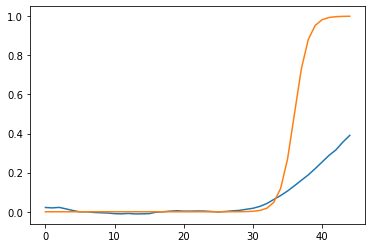

In [168]:
guessfit=fitfunc(df['Cycle'].values,*guessparams)
plt.plot(df['Cycle'].values,df['A1'].values)
plt.plot(df['Cycle'].values,guessfit)
plt.show();

Obviously we have some fitting to do, we will use curve_fit from scipy.optimize to do the fitting.

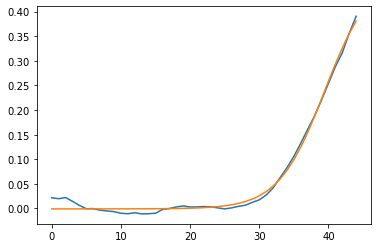

In [169]:
#test out a fit
fitparams,_=so.curve_fit(fitfunc,df['Cycle'].values,df['A1'].values,p0=guessparams,bounds=(lb,ub),method='trf')
plt.plot(df['Cycle'].values,df['A1'].values)
plt.plot(df['Cycle'].values,fitfunc(df['Cycle'].values,*fitparams))
plt.show()

In [170]:
#what were the best fit parameters?
fitparams

array([-7.99398608e-04,  4.78787731e-01,  3.94409066e+01,  3.00079901e-01])

# Fit all the data and annotate

Now we want to fit ALL of the columns, it is easy to process all of the columns at once using pandas "apply" function.

In [171]:
allfitparams = df.iloc[:,1:].apply(lambda x: so.curve_fit(fitfunc,df['Cycle'].values,
                                           x.values,p0=guessparams,bounds=(lb,ub),method='trf')[0])
allfitparams

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P6,P7,P8,P9,P16,P17,P18,P22,P23,P24
0,-0.000799,-0.001838,-0.006905,0.002039,0.001869,-0.011554,0.001776,0.003996,-0.011043,0.002154,...,-0.011897,0.000815,0.001370,-0.011705,0.000878,0.000946,-0.005393,-0.012061,-0.007561,-0.006150
1,0.478788,1.291934,2.210948,-0.016253,-0.012494,2.145053,-0.009896,-0.024128,2.090890,-0.020097,...,2.284975,-0.006457,-0.007544,2.120001,-0.010900,-0.011482,1.971571,1.704303,2.069177,1.952235
2,39.440907,37.427944,29.293167,39.239305,39.631263,25.933741,38.501132,40.052265,26.212965,39.439322,...,25.470309,38.905919,38.924150,25.735880,37.355685,39.760746,34.864014,33.408489,32.433184,31.974420
3,0.300080,0.471699,0.487588,0.453270,0.480993,0.469922,0.833469,0.635426,0.455376,0.462512,...,0.476987,0.988328,0.873247,0.481758,0.539699,0.388927,0.555163,0.362225,0.485218,0.552432


This puts the columns still as the wells and the rows as the fit parameters, let's flip the axes and give the parameters useful names.

In [172]:
allfitparams = allfitparams.T.reset_index()
allfitparams.columns = ['well', 'bias', 'amplitude', 'exponent', 'offset']
allfitparams.head()

,well,bias,amplitude,exponent,offset
0,A1,-0.000799,0.478788,39.440907,0.300080
1,A2,-0.001838,1.291934,37.427944,0.471699
2,A3,-0.006905,2.210948,29.293167,0.487588
3,A4,0.002039,-0.016253,39.239305,0.453270
4,A5,0.001869,-0.012494,39.631263,0.480993


Let's add a field for whether this well was a control or not.

In [173]:
allfitparams['Condition'] = ''
allfitparams.iloc[1::3,allfitparams.columns.get_indexer(['Condition'])] = 'Experiment'
allfitparams.iloc[0::3,allfitparams.columns.get_indexer(['Condition'])] = 'NegativeControl'
allfitparams.iloc[2::3,allfitparams.columns.get_indexer(['Condition'])] = 'PositiveControl'

And we will add fields for the Row in our well plate and the Column that this was from.

In [174]:
allfitparams['Row'] = allfitparams['well'].str[0]
allfitparams['Column'] = allfitparams['well'].str[1:].astype(int)
allfitparams.head()

,well,bias,amplitude,exponent,offset,Condition,Row,Column
0,A1,-0.000799,0.478788,39.440907,0.300080,NegativeControl,A,1
1,A2,-0.001838,1.291934,37.427944,0.471699,Experiment,A,2
2,A3,-0.006905,2.210948,29.293167,0.487588,PositiveControl,A,3
3,A4,0.002039,-0.016253,39.239305,0.453270,NegativeControl,A,4
4,A5,0.001869,-0.012494,39.631263,0.480993,Experiment,A,5


# Use Seaborn and Plotly to look at the results

## Scatterplot

First we'll look at a scatterplot of the amplitude vs. the exponent.

<AxesSubplot:xlabel='exponent', ylabel='amplitude'>

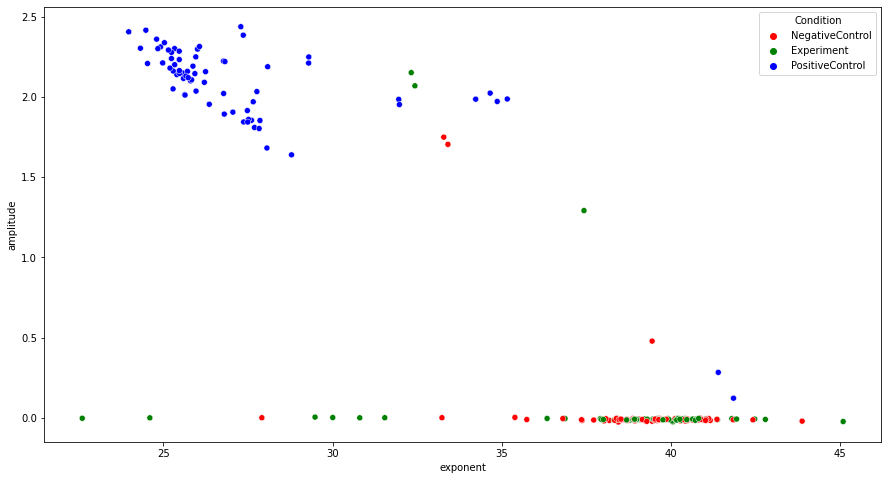

In [175]:
plt.figure(figsize=[15,8])
sns.scatterplot(data=allfitparams, x='exponent', y='amplitude', hue='Condition', palette=['r', 'g', 'b'])

Plotly let's us mouse over the plot point to see which well it is.

In [176]:
px.scatter(allfitparams, x='exponent', y='amplitude', hover_data=['well'], color='Condition')

## Heatmap

Now we will make a pivot table of just the fit amplitudes, and arrange it in the same way as the well plate itself:  Row X Column

In [208]:
amplitude_df = allfitparams.pivot_table(index='Row', columns='Column', values='amplitude').fillna(0)
amplitude_df.columns = 'C'+ (amplitude_df.columns).astype(str)
amplitude_df.head()

Column,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C16,C17,C18,C22,C23,C24
Row,,,,,,,,,,,,,,,,,,
A,0.478788,1.291934,2.210948,-0.016253,-0.012494,2.145053,-0.009896,-0.024128,2.090890,-0.020097,-0.001855,1.809464,0.0,0.0,0.0,-0.025308,-0.013644,0.123220
B,-0.019427,-0.012698,1.905215,-0.015840,-0.005299,2.249400,-0.011367,-0.008220,2.300816,-0.010495,-0.006875,2.223239,0.0,0.0,0.0,-0.018284,-0.013749,0.283876
C,-0.015108,-0.009017,1.854521,-0.017961,-0.013499,2.036207,-0.008271,-0.004835,2.013709,-0.003403,-0.006765,2.405481,0.0,0.0,0.0,0.000000,0.000000,0.000000
D,-0.015205,-0.012813,1.639123,-0.009916,-0.010646,2.277487,-0.004983,-0.003612,2.359703,0.001480,-0.010606,1.853080,0.0,0.0,0.0,0.000000,0.000000,0.000000
E,-0.014686,-0.010660,1.681811,-0.018100,-0.018916,1.843991,-0.008511,-0.008395,2.239219,-0.004976,-0.003585,2.437423,0.0,0.0,0.0,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='Column', ylabel='Row'>

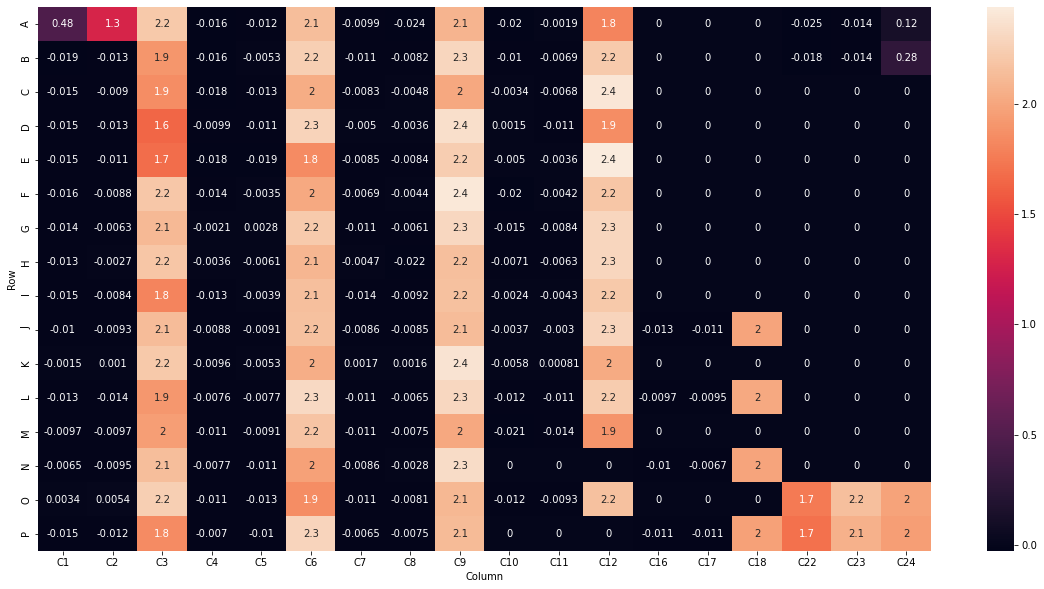

In [209]:
plt.figure(figsize=[20,10])

sns.heatmap(amplitude_df, annot=True)

In [210]:
px.imshow(amplitude_df, width=900, height=700)